In [1]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=609d1db03caad534a150a12b180550eae14a4b2c53deb0369ba45e3a732d90c6
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [2]:
!pip install torchsummary

In [3]:
import numpy as np
import math
import sys
import time
import os
import cv2
import pandas as pd
import random
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as T

# adaugate pt. vizualizare , modele etc..
from torchvision import datasets, models, transforms, utils  
from torch.utils.data import Dataset, DataLoader


# adaugat pt. summary
from torchsummary import summary


# pentru vizualizari
from matplotlib import pyplot as plt

# verificare dipozitiv disponibil (de regula GPU)
is_use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if is_use_cuda else "cpu")
print('Platforma de lucru  : ',device)



Platforma de lucru  :  cuda:0


In [4]:
imsize=64;  
datagen=False
dataset='ocular'

# poreluare etichetare in format df 
import pandas as pd
import numpy as np 
df = pd.read_csv("/kaggle/input/ocular-disease-recognition-odir5k/full_df.csv")
df.shape[0]

#etichetare clase 
def has_normal(text):
    if "normal" in text:
        return 1
    else:
        return 0
def has_cataract(text):
    if "cataract" in text:
        return 1
    else:
        return 0
def has_diabetes(text):
    if "retinopathy" in text:
        return 1
    else:
        return 0
def has_glaucoma(text):
    if "glaucoma" in text:
        return 1
    else:
        return 0
def has_degeneration(text):
    if "age-related macular degeneration" in text:
        return 1
    else:
        return 0
def has_hypertension(text):
    if "hypertensive" in text:
        return 1
    else:
        return 0
def has_myopia(text):
    if "pathological myopia" in text:
        return 1
    else:
        return 0 

df["left_normal"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_normal(x))
df["right_normal"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_normal(x))
left_normal = df.loc[(df.N ==1) & (df.left_normal == 1)]["Left-Fundus"].values
left_normal
right_normal = df.loc[(df.N ==1) & (df.right_normal == 1)]["Right-Fundus"].values
right_normal
print("Number of images in left normal: {}".format(len(left_normal)))
print("Number of images in right normal: {}".format(len(right_normal)))
print()


df["left_cataract"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_cataract(x))
df["right_cataract"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_cataract(x))
left_cataract = df.loc[(df.C ==1) & (df.left_cataract == 1)]["Left-Fundus"].values
left_cataract
right_cataract = df.loc[(df.C ==1) & (df.right_cataract == 1)]["Right-Fundus"].values
right_cataract
print("Number of images in left cataract: {}".format(len(left_cataract)))
print("Number of images in right cataract: {}".format(len(right_cataract)))
print()


df["left_diabetes"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_diabetes(x))
df["right_diabetes"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_diabetes(x))
left_diabetes = df.loc[(df.D ==1) & (df.left_diabetes == 1)]["Left-Fundus"].values
right_diabetes = df.loc[(df.D ==1) & (df.right_diabetes == 1)]["Right-Fundus"].values
diabetes_images = np.concatenate((left_diabetes, right_diabetes))
print("Number of images in left diabetes: {}".format(len(left_diabetes)))
print("Number of images in right diabetes: {}".format(len(right_diabetes)))
print()


df["left_glaucoma"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_glaucoma(x))
df["right_glaucoma"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_glaucoma(x))
left_glaucoma = df.loc[(df.G ==1) & (df.left_glaucoma == 1)]["Left-Fundus"].values
left_glaucoma
right_glaucoma = df.loc[(df.G ==1) & (df.right_glaucoma == 1)]["Right-Fundus"].values
right_glaucoma
print("Number of images in left glaucoma: {}".format(len(left_glaucoma)))
print("Number of images in right glaucoma: {}".format(len(right_glaucoma)))
print()


df["left_degeneration"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_degeneration(x))
df["right_degeneration"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_degeneration(x))
left_degeneration = df.loc[(df.A ==1) & (df.left_degeneration == 1)]["Left-Fundus"].values
left_degeneration
right_degeneration = df.loc[(df.A ==1) & (df.right_degeneration == 1)]["Right-Fundus"].values
right_degeneration
print("Number of images in left degeneration: {}".format(len(left_degeneration)))
print("Number of images in right degeneration: {}".format(len(right_degeneration)))
print()


df["left_myopia"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_myopia(x))
df["right_myopia"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_myopia(x))
left_myopia = df.loc[(df.M ==1) & (df.left_myopia == 1)]["Left-Fundus"].values
left_myopia
right_myopia = df.loc[(df.M ==1) & (df.right_myopia == 1)]["Right-Fundus"].values
right_myopia
print("Number of images in left myopia: {}".format(len(left_myopia)))
print("Number of images in right myopia: {}".format(len(right_myopia)))
print()


df["left_hypertension"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_hypertension(x))
df["right_hypertension"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_hypertension(x))
left_hypertension = df.loc[(df.H ==1) & (df.left_hypertension == 1)]["Left-Fundus"].values
left_hypertension
right_hypertension = df.loc[(df.H ==1) & (df.right_hypertension == 1)]["Right-Fundus"].values
right_hypertension
print("Number of images in left hypertension: {}".format(len(left_hypertension)))
print("Number of images in right hypertension: {}".format(len(right_hypertension)))
print()


left_abnormalities = df.loc[(df.C ==0) & (df.N ==0) & (df.D ==0) & (df.G ==0) & (df.A ==0)& (df.M ==0) & (df.H ==0)]["Left-Fundus"].sample(250,random_state=42).values
left_abnormalities
right_abnormalities = df.loc[(df.C ==0) & (df.N ==0) & (df.D ==0) & (df.G ==0) & (df.A ==0)& (df.M ==0) & (df.H ==0) ]["Right-Fundus"].sample(250,random_state=42).values
right_abnormalities
print("Number of images in left abnormalities: {}".format(len(left_abnormalities)))
print("Number of images in right abnormalities: {}".format(len(right_abnormalities)))
print()

left_cataract[:10], left_normal[:10], left_glaucoma[:10], left_myopia[:10]

cataract = np.concatenate((left_cataract,right_cataract),axis=0)
normal = np.concatenate((left_normal,right_normal),axis=0)
glaucoma = np.concatenate((left_glaucoma,right_glaucoma),axis=0)
diabetes = np.concatenate((left_diabetes,right_diabetes),axis=0)
degeneration = np.concatenate((left_degeneration,right_degeneration),axis=0)
myopia = np.concatenate((left_myopia,right_myopia),axis=0)
hypertension = np.concatenate((left_hypertension,right_hypertension),axis=0)
abnormalities = np.concatenate((left_abnormalities,right_abnormalities),axis=0)

print("Total cataract images: ",len(cataract))
print("Total normal images: ",len(normal))
print("Total galucoma images: ",len(glaucoma)) 
print("Total diabetes images: ",len(diabetes)) 
print("Total degeneration images: ",len(degeneration)) 
print("Total myopia images: ",len(myopia))
print("Total hypertension images: ",len(hypertension)) 
print("Total abnormalities images: ",len(abnormalities))
print()



Number of images in left normal: 2100
Number of images in right normal: 2101

Number of images in left cataract: 304
Number of images in right cataract: 290

Number of images in left diabetes: 1689
Number of images in right diabetes: 1759

Number of images in left glaucoma: 332
Number of images in right glaucoma: 284

Number of images in left degeneration: 266
Number of images in right degeneration: 285

Number of images in left myopia: 216
Number of images in right myopia: 241

Number of images in left hypertension: 191
Number of images in right hypertension: 191

Number of images in left abnormalities: 250
Number of images in right abnormalities: 250

Total cataract images:  594
Total normal images:  4201
Total galucoma images:  616
Total diabetes images:  3448
Total degeneration images:  551
Total myopia images:  457
Total hypertension images:  382
Total abnormalities images:  500



In [5]:
batch_size = 32
num_classes = 6

In [6]:
import torch
from torch import nn
from torch.utils.data import Dataset, ConcatDataset, TensorDataset, DataLoader

print(torch.__version__)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

2.1.2
cuda


In [7]:
class CustomDataset(Dataset):
  def __init__(self, image_category, label, dataset_dir, image_size=64):
    self.image_category = image_category
    self.label = label
    self.dataset_dir = dataset_dir
    self.image_size = image_size
    self.data = self.create_dataset()

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    img, label = self.data[idx]
    return img, label

  def create_dataset(self):
    dataset = []
    dataset_label = []
    for img in tqdm(self.image_category):
      image_path = os.path.join(self.dataset_dir, img)
      try:
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        # Convert BGR to RGB 
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (self.image_size, self.image_size))
      except:
        continue

      dataset.append([np.array(image), np.array(self.label)])
    random.shuffle(dataset)
    return dataset

In [8]:
dataset_normal = CustomDataset(image_category = normal,
                                 label = 0,
                                 dataset_dir = "/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/",
                                 image_size = 64)

dataset_cataract = CustomDataset(image_category = cataract,
                                 label = 1,
                                 dataset_dir = "/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/",
                                 image_size = 64)

dataset_glaucoma = CustomDataset(image_category = glaucoma,
                                 label = 2,
                                 dataset_dir = "/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/",
                                 image_size = 64)

dataset_myopia = CustomDataset(image_category = myopia,
                                 label = 3,
                                 dataset_dir = "/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/",
                                 image_size = 64)

dataset_diabetes = CustomDataset(image_category = diabetes,
                                 label = 4,
                                 dataset_dir = "/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/",
                                 image_size = 64)

dataset_hypertension = CustomDataset(image_category = hypertension,
                                 label = 5,
                                 dataset_dir = "/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/",
                                 image_size = 64)

  0%|          | 0/4201 [00:00<?, ?it/s]

[ WARN:0@6.342] global loadsave.cpp:241 findDecoder imread_('/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/2400_left.jpg'): can't open/read file: check file path/integrity
[ WARN:0@7.157] global loadsave.cpp:241 findDecoder imread_('/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/2495_left.jpg'): can't open/read file: check file path/integrity
[ WARN:0@7.158] global loadsave.cpp:241 findDecoder imread_('/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/2496_left.jpg'): can't open/read file: check file path/integrity
[ WARN:0@7.777] global loadsave.cpp:241 findDecoder imread_('/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/2571_left.jpg'): can't open/read file: check file path/integrity
[ WARN:0@7.838] global loadsave.cpp:241 findDecoder imread_('/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/2580_left.jpg'): can't open/read file: check file path/integrity
[ WARN:0@7.913] global loadsav

  0%|          | 0/594 [00:00<?, ?it/s]

[ WARN:0@33.498] global loadsave.cpp:241 findDecoder imread_('/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/2102_left.jpg'): can't open/read file: check file path/integrity
[ WARN:0@34.241] global loadsave.cpp:241 findDecoder imread_('/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/2231_left.jpg'): can't open/read file: check file path/integrity
[ WARN:0@34.318] global loadsave.cpp:241 findDecoder imread_('/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/2244_left.jpg'): can't open/read file: check file path/integrity
[ WARN:0@34.342] global loadsave.cpp:241 findDecoder imread_('/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/2251_left.jpg'): can't open/read file: check file path/integrity
[ WARN:0@36.139] global loadsave.cpp:241 findDecoder imread_('/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/1456_right.jpg'): can't open/read file: check file path/integrity
[ WARN:0@36.425] global 

  0%|          | 0/616 [00:00<?, ?it/s]

[ WARN:0@37.482] global loadsave.cpp:241 findDecoder imread_('/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/1412_left.jpg'): can't open/read file: check file path/integrity
[ WARN:0@37.723] global loadsave.cpp:241 findDecoder imread_('/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/1475_left.jpg'): can't open/read file: check file path/integrity
[ WARN:0@37.862] global loadsave.cpp:241 findDecoder imread_('/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/1865_left.jpg'): can't open/read file: check file path/integrity


  0%|          | 0/457 [00:00<?, ?it/s]

[ WARN:0@40.506] global loadsave.cpp:241 findDecoder imread_('/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/1540_left.jpg'): can't open/read file: check file path/integrity
[ WARN:0@41.064] global loadsave.cpp:241 findDecoder imread_('/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/1657_left.jpg'): can't open/read file: check file path/integrity
[ WARN:0@42.759] global loadsave.cpp:241 findDecoder imread_('/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/39_right.jpg'): can't open/read file: check file path/integrity


  0%|          | 0/3448 [00:00<?, ?it/s]

[ WARN:0@43.084] global loadsave.cpp:241 findDecoder imread_('/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/2_left.jpg'): can't open/read file: check file path/integrity
[ WARN:0@43.180] global loadsave.cpp:241 findDecoder imread_('/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/50_left.jpg'): can't open/read file: check file path/integrity
[ WARN:0@43.220] global loadsave.cpp:241 findDecoder imread_('/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/74_left.jpg'): can't open/read file: check file path/integrity
[ WARN:0@43.251] global loadsave.cpp:241 findDecoder imread_('/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/90_left.jpg'): can't open/read file: check file path/integrity
[ WARN:0@43.262] global loadsave.cpp:241 findDecoder imread_('/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/108_left.jpg'): can't open/read file: check file path/integrity
[ WARN:0@43.430] global loadsave.cp

  0%|          | 0/382 [00:00<?, ?it/s]

[ WARN:0@70.043] global loadsave.cpp:241 findDecoder imread_('/kaggle/input/ocular-disease-recognition-odir5k/preprocessed_images/305_left.jpg'): can't open/read file: check file path/integrity


In [9]:
dataset = ConcatDataset([dataset_cataract, dataset_normal, dataset_glaucoma, dataset_myopia, dataset_diabetes, dataset_hypertension])

print("Combined dataset length:", len(dataset))

Combined dataset length: 9585


In [ ]:
plt.figure(figsize=(12, 4))
rows, cols = 2, 8
for i in range(1, rows*cols + 1):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]

    if category == 0:
        label = "Normal"
    elif category == 1:
        label = "Cataract"
    elif category == 2:
        label = "Glaucoma"
    elif category == 3:
        label = "Myopia"
    elif category == 4:
        label = "Diabetes"
    elif category == 5:
        label = "Hypertension"

    plt.subplot(rows, cols, i)
    plt.imshow(image)
    plt.title(label)
    plt.axis(False)
plt.tight_layout()


In [ ]:
dataset[0][0].shape
input_shape = np.transpose(dataset[0][0], (2, 0, 1))
print(input_shape.shape)

(3, 64, 64)


In [ ]:
# Reshaping image dataset to load in tensor
X = np.array([i[0] for i in dataset]).reshape(-1, 64, 64, 3)
y = np.array([i[1] for i in dataset])

In [13]:
# Conversion into tensors from arrays
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.long)

X[0], y[:10]

(tensor([[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         ...,
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]],
 
         [[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.],
          ...,
          [0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]]),
 tensor([1, 

In [14]:
""" Train/Test Split"""

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2,
                                                    shuffle = True,
                                                    random_state = 42)

len(X_train), len(X_test), y_train[:10]

(7668, 1917, tensor([0, 4, 0, 0, 4, 4, 0, 4, 4, 4]))

In [15]:
X_train.shape

torch.Size([7668, 64, 64, 3])

In [16]:
# Permute the color channel index to front
X_train, X_test = X_train.permute(0, 3, 1, 2), X_test.permute(0, 3, 1, 2)

In [17]:
 #Turn datasets into batches
BATCH_SIZE = 32

train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(dataset = train_dataset,
                              batch_size = BATCH_SIZE,
                              shuffle = False)      # Shuffle false cuz already shuffled using sklearn->train_test_spilt

test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(dataset = test_dataset,
                             batch_size = BATCH_SIZE,
                             shuffle = False)

len(train_dataloader), len(test_dataloader)

(240, 60)

Learning rate per epoch:


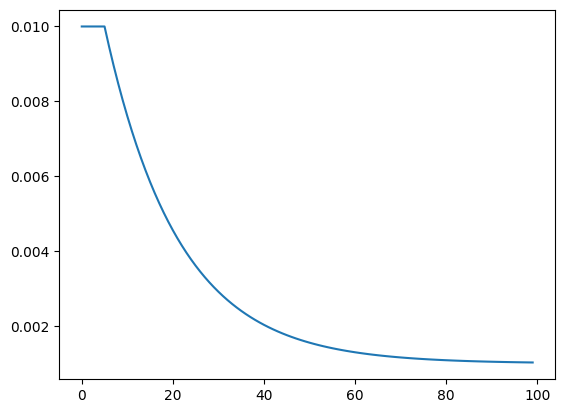

In [18]:
# DEFINIRE FUNCTII ANTRENARE SI TESTARE inclusiv "learning rate schedule" (plan de evolutie a ratei de antrenare)
#
#=========================================================
# adaptat dupa https://github.com/luuuyi/SqueezeNext.PyTorch/blob/master/SqueezeNext.ipynb
rata_antren_constanta=False # True sau False -
num_epochs=100
start_lr=0.01 # rata de antrenare la pornire
criterion = nn.CrossEntropyLoss()


def lr_schedule(start_lr, epoch):
      # parametri evolutie
      #
      if rata_antren_constanta:
        min_lr=start_lr; max_lr=start_lr; exp_decay=1  # rata de antrenare constanta
      else:
        min_lr = 0.001; max_lr = 0.01; exp_decay = .94 # rate de antrenare dupa o schema prestabilita

      rampup_epochs = 5; sustain_epochs = 0;
      if epoch < rampup_epochs:
        return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
      elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
      else:
        return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr

# Vizualizare training schedule
from matplotlib import pyplot as plt
rang = np.arange(num_epochs)
y = [lr_schedule(start_lr,x) for x in rang]
plt.plot(rang, y)
print('Learning rate per epoch:')

# definire bucla de antrenare ------------------------------------------
def train(epoch):
    net.train()
    train_loss = 0
    correct    = 0
    total      = 0
    optimizer  = optim.SGD(net.parameters(), lr=lr_schedule(start_lr, epoch), momentum=0.9, weight_decay=5e-4)
    # se poate utiliza una din cele 2 variante de lr_schedule
    # Aici s-a ales optimizerul SGD
    #optimizer = optim.Adam(net.parameters(),lr=lr_schedule(lr, epoch))

    print('Training Epoch: #%d, LR: %.4f'%(epoch, lr_schedule(start_lr, epoch))) # atentie schimbare lr_schedule
    for idx, (inputs, labels) in enumerate(train_loader):
        if is_use_cuda:
            inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs        = net(inputs)
        loss           = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predict = torch.max(outputs, 1)
        total      += labels.size(0)
        correct    += predict.eq(labels).cpu().sum().double()

        sys.stdout.write('\r')
        sys.stdout.write('[%s] Training Epoch [%d/%d] Iter[%d/%d]\t\tLoss: %.4f Acc@1: %.3f'
                        % (time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time())),
                           epoch, num_epochs, idx, len(train_loader),
                          train_loss / ( (idx + 1)), correct / total))
        sys.stdout.flush()

    #print('total: ', total, 'correct: ',correct)
    #print('train-loss: ', train_loss/(idx+1))
    return train_loss/(idx+1) , correct / total  #/ (batch_size * (idx + 1))

# ---------definire bucla de testare inclusiv "checkpoint" cu salvarea modelului optim (acuratete maxima pe testare)
def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct   = 0
    total     = 0

    for idx, (inputs, labels) in enumerate(test_loader):
        #print(idx)
        if is_use_cuda:
            inputs, labels = inputs.to(device), labels.to(device)
        outputs        = net(inputs)
        loss           = criterion(outputs, labels)

        test_loss  += loss.item()
        #print('test loss:',test_loss)
        _, predict = torch.max(outputs, 1)
        total      += labels.size(0)
        correct    += predict.eq(labels).cpu().sum().double()

        sys.stdout.write('\r')
        sys.stdout.write('[%s] Test Epoch [%d/%d] Iter[%d/%d]\t\tLoss: %.4f Acc@1: %.3f'
                        % (time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time())),
                           epoch, num_epochs, idx, len(test_loader),   # aici test_batch=80
                          test_loss / ( (idx + 1)), correct / total))     # aici test_batch=100
        sys.stdout.flush()


    if correct / total > best_acc:
        print()
        print('Saving Model...')
        state = {
                'net': net.module if is_use_cuda else net,
                'acc': correct / total,
                'epoch': epoch
                }
        if not os.path.isdir('./checkpoint/'):
            os.makedirs('./checkpoint/')
        torch.save(state, './checkpoint/best_model.ckpt')
        best_acc = correct / total
   
    return test_loss/ (idx+1) , correct / total  #/ (test_batch * (idx + 1))

In [19]:
from efficientnet_pytorch import EfficientNet; net = EfficientNet.from_pretrained('efficientnet-b0', num_classes=num_classes); net_name='6_EffB0'

if is_use_cuda:
    net.to(device)
    net = nn.DataParallel(net, device_ids=range(torch.cuda.device_count()))
input_shape = (3, 64, 64)

summary(net.to(device), input_size = input_shape, batch_size = -1)  # vizualizare model
# Calcul dimensiune model (numar parametri)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Numar parametri model: ',count_parameters(net.to(device)))
def display_training_curves(training, test, title, subplot):

    if subplot%10==1: # set up the subplots on the first call

        plt.subplots(figsize=(8,2), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(test)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    # ax.set_ylim(0,10)

    ax.set_xlabel('epoch')
    ax.legend(['train', 'test'])


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 218MB/s]


Loaded pretrained weights for efficientnet-b0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1            [-1, 3, 65, 65]               0
Conv2dStaticSamePadding-2           [-1, 32, 32, 32]             864
       BatchNorm2d-3           [-1, 32, 32, 32]              64
MemoryEfficientSwish-4           [-1, 32, 32, 32]               0
         ZeroPad2d-5           [-1, 32, 34, 34]               0
Conv2dStaticSamePadding-6           [-1, 32, 32, 32]             288
       BatchNorm2d-7           [-1, 32, 32, 32]              64
MemoryEfficientSwish-8           [-1, 32, 32, 32]               0
          Identity-9             [-1, 32, 1, 1]               0
Conv2dStaticSamePadding-10              [-1, 8, 1, 1]             264
MemoryEfficientSwish-11              [-1, 8, 1, 1]               0
         Identity-12              [-1, 8, 1, 1]               0
Conv2dStaticSamePadding-13        

In [20]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Training Epoch: #1, LR: 0.0100
[2024-06-05 17:25:27] Training Epoch [1/20] Iter[239/240]		Loss: 1.2754 Acc@1: 0.474
[2024-06-05 17:25:35] Test Epoch [1/20] Iter[59/60]		Loss: 1.1570 Acc@1: 0.508
Saving Model...


Epoch #1 duration: 57s
Training Epoch: #2, LR: 0.0100
[2024-06-05 17:26:24] Training Epoch [2/20] Iter[239/240]		Loss: 1.0448 Acc@1: 0.558
[2024-06-05 17:26:32] Test Epoch [2/20] Iter[59/60]		Loss: 0.9996 Acc@1: 0.587
Saving Model...


Epoch #2 duration: 56s
Training Epoch: #3, LR: 0.0100
[2024-06-05 17:27:22] Training Epoch [3/20] Iter[239/240]		Loss: 0.8676 Acc@1: 0.626
[2024-06-05 17:27:30] Test Epoch [3/20] Iter[59/60]		Loss: 0.9065 Acc@1: 0.619
Saving Model...


Epoch #3 duration: 57s
Training Epoch: #4, LR: 0.0100
[2024-06-05 17:28:19] Training Epoch [4/20] Iter[239/240]		Loss: 0.7445 Acc@1: 0.684
[2024-06-05 17:28:27] Test Epoch [4/20] Iter[59/60]		Loss: 0.8874 Acc@1: 0.634
Saving Model...


Epoch #4 duration: 57s
Training Epoch: #5, LR: 0.0100
[2024-06-05 17:29:16] Tra

/tmp/ipykernel_33/4118584900.py:19: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


<Figure size 640x480 with 0 Axes>

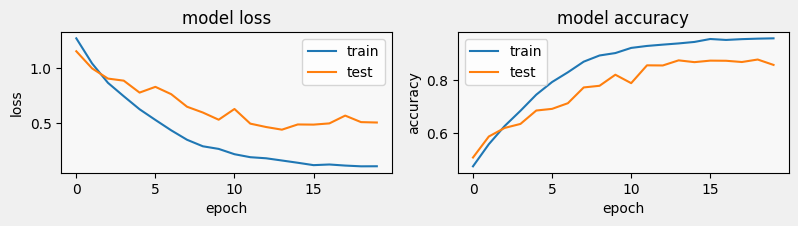

In [21]:
# ANTRENARE SI VALIDARE CU RAPORTARE REZULTATE
#==============================================================
# adaptat dupa https://github.com/luuuyi/SqueezeNext.PyTorch/blob/master/SqueezeNext.ipynb
start_epoch=1
num_epochs=20
best_acc=0.0 #

import time
torch.autograd.set_detect_anomaly(True)
# --- adaugat pentru a monitoriza evolutia -------------------------------
history = {} # Collects per-epoch loss and acc like Keras' fit().
history['loss'] = []
history['val_loss'] = []
history['acc'] = []
history['val_acc'] = []
#-----------------------------------------------------------
for _epoch in range(start_epoch, start_epoch + num_epochs):
    start_time = time.time()
    tr_loss, tr_acc = train(_epoch)
    print()
    ts_loss, ts_acc = test(_epoch)
    history['loss'].append(tr_loss)
    history['val_loss'].append(ts_loss)
    history['acc'].append(tr_acc)
    history['val_acc'].append(ts_acc)
    print()
    print()
    end_time   = time.time()
    print('Epoch #%d duration: %ds' % (_epoch, end_time - start_time))
    
    
print('xxxxxxxxxxxxxxxxxxxxxxx  REPORT xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx')
print('Dataset :',dataset)
print('Best valid accuracy: %.4f %%' % (best_acc * 100))
print('Numar parametri model: ',count_parameters(net))
print('Batch_size: ', batch_size)
print('Epoci: ', num_epochs)
print('Num_classes: ',num_classes)
print('Input-shape: ',input_shape)
print('Model name: ', net_name)
print('xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx')
plt.clf()
display_training_curves(history['loss'], history['val_loss'], 'loss', 121)
#plt.clf()
display_training_curves(history['acc'], history['val_acc'], 'accuracy', 122)


In [24]:
import torch

# Încarcă modelul optim
best = torch.load('./checkpoint/best_model.ckpt')
best_model = best["net"]
best_acc = best['acc']

# Salvează modelul PyTorch
torch.save(best_model, net_name + '__' + str(int(best_acc * 10000)) + '.pt')
print('Ultimele 4 cifre divizate cu 100 indica acuratetea pe date de validare (in %)')


Ultimele 4 cifre divizate cu 100 indica acuratetea pe date de validare (in %)


In [26]:
import torch
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Încărcăm modelul salvat în PyTorch
model = torch.load('/kaggle/working/6_EffB0__8774.pt')
model.eval()  # Setați modelul în modul de evaluare

# Verificăm dacă y_test este one-hot encoded
if len(y_test.shape) > 1 and y_test.shape[1] > 1:
    labels = np.argmax(y_test, axis=1)
else:
    labels = y_test

# Verificați tipul datelor lui X_test
if isinstance(X_test, torch.Tensor):
    # Dacă X_test este un tensor PyTorch, nu este necesară conversia
    X_test_tensor = X_test.float()
else:
    # Dacă X_test este un array NumPy, îl convertim într-un tensor PyTorch
    X_test_tensor = torch.from_numpy(X_test).float()

# Dacă utilizați GPU, mutați datele pe GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
X_test_tensor = X_test_tensor.to(device)

# Facem predicțiile
with torch.no_grad():
    outputs = model(X_test_tensor)
    _, predicted_class_indices = torch.max(outputs, 1)
    predicted_class_indices = predicted_class_indices.cpu().numpy()  # Mutăm predicțiile pe CPU

# Calculăm matricea de confuzie
C = confusion_matrix(labels, predicted_class_indices)
print(C)

# Generăm raportul de clasificare
print('Classification Report')
print(classification_report(labels, predicted_class_indices))


[[757   8   7   0  54   5]
 [  1 115   1   0   3   0]
 [ 12   0 101   0   9   3]
 [  0   0   0  77   3   0]
 [ 42   8  15   4 578  32]
 [  4   1   2   0  21  54]]
Classification Report
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       831
           1       0.87      0.96      0.91       120
           2       0.80      0.81      0.80       125
           3       0.95      0.96      0.96        80
           4       0.87      0.85      0.86       679
           5       0.57      0.66      0.61        82

    accuracy                           0.88      1917
   macro avg       0.83      0.86      0.84      1917
weighted avg       0.88      0.88      0.88      1917

